In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
input_data = { 'game_id': {'player_name': 'NEW',
                                'x': 10,
                                'y':20,
                                'kill': 1,
                                'coin': 2,
                                'shot': 10
                            }
            }



In [5]:
df = pd.read_excel('game_trainingset.xlsx')
df.set_index('game_id',inplace=True)
df.head()

,player,pos_x,pos_y,kill,coin,shot
game_id,,,,,,
1,NEW,6,34,34,13,48
2,NEW,52,95,53,39,135
3,NEW,63,85,11,83,30
4,NEW,21,66,16,54,86
5,NEW,32,33,27,84,64


In [6]:
df['shot_wo_kill'] = df['shot'] - df['kill']
df.head()

,player,pos_x,pos_y,kill,coin,shot,shot_wo_kill
game_id,,,,,,,
1,NEW,6,34,34,13,48,14
2,NEW,52,95,53,39,135,82
3,NEW,63,85,11,83,30,19
4,NEW,21,66,16,54,86,70
5,NEW,32,33,27,84,64,37


In [32]:
df.groupby('player')[col].mean()

,pos_x,pos_y,kill,coin,shot,shot_wo_kill
player,,,,,,
KONG,28.8,63.0,27.8,49.8,88.3,60.5
NEW,39.2,55.6,26.6,53.3,82.3,55.7
PURI,45.6,54.6,30.2,46.3,83.3,53.1
YO,63.0,40.4,27.8,51.4,68.6,40.8


In [7]:
df.columns

Index(['player', 'pos_x', 'pos_y', 'kill', 'coin', 'shot', 'shot_wo_kill'], dtype='object')

In [9]:
col = ['pos_x', 'pos_y', 'kill', 'coin', 'shot', 'shot_wo_kill']
df2 = df[col]

In [ ]:
import pickle
filehandler = open(b"Fruits.obj","wb")
pickle.dump(banana,filehandler)

In [15]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(df2)
df2_tf = pd.DataFrame(mm_scaler.transform(df2), index=df.index, columns=col)

DIR_TRANSFORM_MODEL = './scaler_model.pkl'
pickle.dump(mm_scaler, open(DIR_TRANSFORM_MODEL,'wb'))

In [29]:
kmeans = KMeans(n_clusters = 4, random_state=0)
kmeans.fit(df2_tf[col])
df2['cluster'] = kmeans.predict(df2_tf[col])
df2.head()

,pos_x,pos_y,kill,coin,shot,shot_wo_kill,cluster
game_id,,,,,,,
1,6,34,34,13,48,14,2
2,52,95,53,39,135,82,3
3,63,85,11,83,30,19,0
4,21,66,16,54,86,70,1
5,32,33,27,84,64,37,0


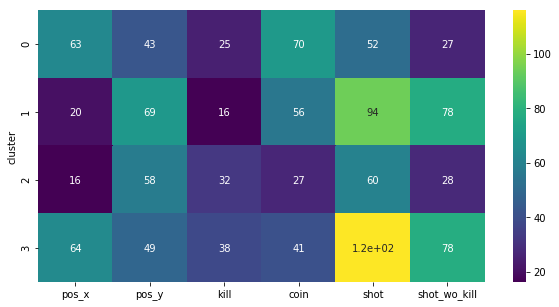

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.groupby('cluster').mean(), cmap='viridis', annot=True )

In [40]:
X = df2[col]
y = df2['cluster']

In [45]:
y_unique_lst = sorted(y.unique().tolist())
i = 0
fig, ax = plt.subplots(len(y_unique_lst), 1, figsize=(20,60), dpi = 300)
for cluster in y_unique_lst:
    new_y = y == cluster
    dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
    dtree.fit(X, new_y)
    tree.plot_tree(
            dtree,
            feature_names = col,
            # class_names = (new_y * cluster).astype(str),
            filled = True,
            ax = ax[i]
  );
    ax[i].set_title(f'--------------------- CLUSTER NUMBER : {cluster} --------------------- ')
    i+=1
fig.savefig('./dendrogram_one_vs_rest.png')

In [27]:
mss = 'yo,100,puri,105,a,200,v,400,p,1000'
mss_split = mss.split(',')
score = [(int(mss_split[i-1]), mss_split[i]) for i in range(len(mss_split)) if i%2==0] 

new_score = (300,'new')
score.append(new_score)

score.sort(reverse=True)
score[:5]

In [28]:
score

[(1000, 'yo'), (100, 'puri'), (105, 'a'), (200, 'v'), (400, 'p')]

[(1000, 'yo'), (400, 'p'), (300, 'new'), (200, 'v'), (105, 'a')]